#  Mean Shift algorithm - Image segmentation example

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.cluster import MeanShift, estimate_bandwidth
from matplotlib import pyplot as plt, style
import matplotlib.image as mpimg
from LUV_RGB_converter import RGBtoLUV, LUVtoRGB 
style.use("ggplot")

## Image overview

n_vert:	3456
    n_hor:	4608
    n_colors:3


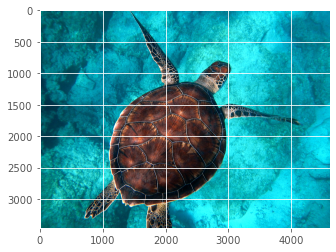

In [2]:
filename = "tortue.jpg"  
# JPG : RGB [3 colors)
# PNG : RGBA [4 colors: RGB + A (transparency)]

# Display original picture
originalimg = mpimg.imread(filename)

n_vert0, n_hor0, n_colors = originalimg.shape
print(f"n_vert:\t{n_vert0}\n\
    n_hor:\t{n_hor0}\n\
    n_colors:{n_colors}")
plt.imshow(originalimg)

## Downsize and Split the image

img_0
y:	35
    x:	92
        n_colors:3


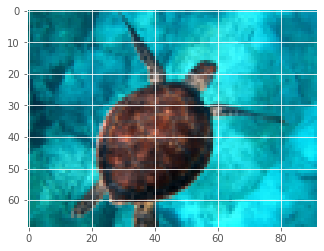

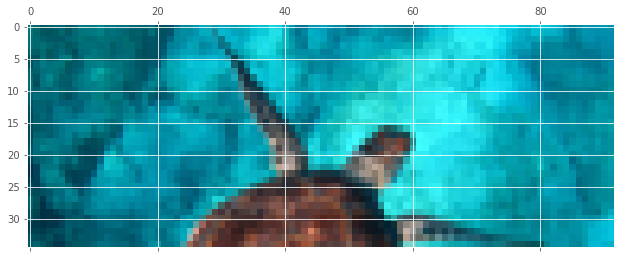

img_1
y:	34
x:	92
n_colors:3


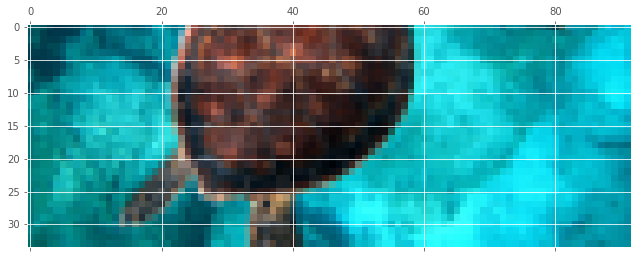

In [3]:
# resizing for speed concern 
img = Image.open(filename)
newimg = img.resize((np.array(img.size)/50).astype(int))
imgplot = plt.imshow(newimg)
img = np.asarray(newimg)

# splitting the image to test prediction
img_split = np.array_split(img, 2)

img_0 = img_split[0]
n_colors = img_0.shape[2]
print(f"img_0\ny:\t{img_0.shape[0]}\n\
    x:\t{img_0.shape[1]}\n\
        n_colors:{img_0.shape[2]}")
plt.matshow(img_0)
plt.show()

img_1 = img_split[1]
n_colors = img_1.shape[2]
print(f"img_1\ny:\t{img_1.shape[0]}\nx:\t{img_1.shape[1]}\nn_colors:{img_1.shape[2]}")
plt.matshow(img_1)
plt.show()

## Convert the image into a vector of *n* dimensions
1. rows: index of pixels
2. columns (features): 3 for JPG (R,G,B) - 4 for PNG (R,G,B,A where A = transparency)

In [4]:
# [number of pixels] x [x,y,r,g,b,A]
X_0 = np.reshape(img_0, (-1, n_colors))
X_1 = np.reshape(img_1, (-1, n_colors))
print(f"Shape of X_0:{X_0.shape}\nShape of X_1:{X_1.shape}")

Shape of X_0:(3220, 3)
Shape of X_1:(3128, 3)


## Change Color Space

In [5]:
# Color space can impact results,
# LUV seems more accurate for computer vision
# "LUV decouple the "color" (chromaticity, the UV part) 
# and "lightness" (luminance, the L part) of color. 
# Thus in object detection, it is common to match objects 
# just based on the UV part, which gives invariance to changes
# in lighting condition."

X_0 = np.apply_along_axis(RGBtoLUV,1,X_0)
print(X_0.shape)

(3220, 3)


## Search for clusters

In [6]:
# Estimate bandwidth for MeanShift algorithm

# If dynamically computed bandwidth
#bandwidth = estimate_bandwidth(X_0, quantile=0.1, n_samples=100)    

# If static bandwidth
#bandwidth = 30

# Instantiate MeanShift
#ms = MeanShift(bandwidth=bandwidth)
ms = MeanShift()
ms = ms.fit(X_0)
# The different clusters found
# Labels of each point
labels = ms.labels_ 
# Coordinates of cluster centers : ndarray of shape (n_clusters, n_features)
cluster_centers = ms.cluster_centers_  

# Number of unique clusters found  
unique_labels = np.unique(labels)      # len(unique_labels) = n_clusters
n_clusters = cluster_centers.shape[0]
print(f"{n_clusters} clusters found with these labels:\n {unique_labels}")

3 clusters found with these labels:
 [0 1 2]


## 3D Plot of clusters and centroids

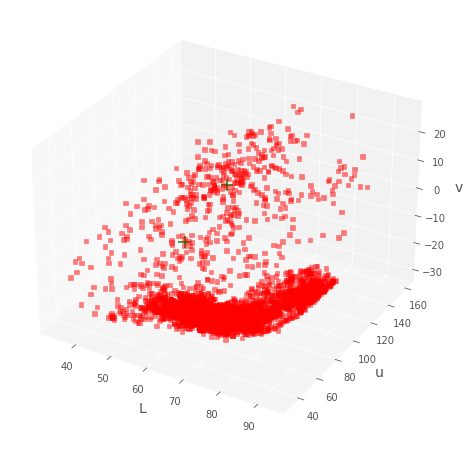

In [7]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection ='3d')
ax.set(facecolor='w')
ax.set_xlabel('L', fontsize=14)
ax.set_ylabel('u', fontsize=14)
ax.set_zlabel('v', fontsize=14)
alpha = 0.5
color_vector = X_0[:,:]/255.
ax.scatter(X_0[:,0],X_0[:,1],X_0[:,2], marker ='s',c='r', alpha=alpha)
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1], cluster_centers[:, 2],
           s=150,marker ='+', c='g', alpha=1., zorder = 10)
plt.show()

## Segmented Image

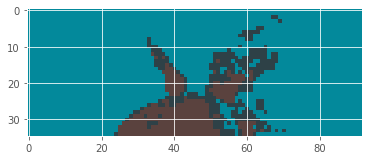

In [8]:
seg_img = []
for l in labels:
    t = tuple(cluster_centers[l])
    seg_img.append(t)
    
seg_img = np.apply_along_axis(LUVtoRGB,1,seg_img)    
seg_img = np.array(seg_img).reshape(img_0.shape).astype(np.uint8)
plt.imshow(seg_img.astype(np.uint8))
plt.imshow(seg_img)

# Prediction

prediction shape:(3128,)
numbers of unique value? 3


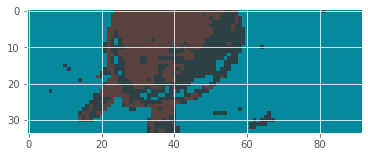

In [9]:
# switch to LUV space
X_1 = np.apply_along_axis(RGBtoLUV,1,X_1)
y_pred = ms.predict(X_1)
u, indices=np.unique(y_pred, return_counts=True)
print(f"prediction shape:{y_pred.shape}\n\
numbers of unique value? {len(u)}")

pred_img = []
for i,y in enumerate(y_pred):
    t = tuple(cluster_centers[y])
    pred_img.append(t)

# switch back to RGB
pred_img = np.apply_along_axis(LUVtoRGB,1,pred_img)

pred_img = np.array(pred_img).reshape(img_1.shape).astype(np.uint8)
plt.imshow(pred_img)